In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_util
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)

device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
data = pd.read_csv('dann_nelec_elec.csv')
DATA = data.iloc[:-1,].reset_index(drop=True)
NELEC = data[['N_ELEC']].iloc[1:].reset_index(drop=True)
NELEC.columns = ['nelec']
ELEC = data[['ELEC']].iloc[1:].reset_index(drop=True)
ELEC.columns = ['elec']

In [4]:
scaler = MinMaxScaler()
scaler.fit(DATA)

scaled = scaler.transform(DATA)
new = pd.DataFrame(scaled, index=DATA.index, columns=DATA.columns)

nelec = pd.concat([new, NELEC], axis=1)
elec = pd.concat([new, ELEC], axis=1)

In [5]:
standard = int(len(nelec) * 0.7)

nelec_train = nelec.iloc[:standard]
nelec_test = nelec.iloc[standard:].reset_index(drop=True)

elec_train = elec.iloc[:standard]
elec_test = elec.iloc[standard:].reset_index(drop=True)

In [6]:
nelec_trainx = nelec_train.drop(['nelec'], axis=1)
nelec_trainy = nelec_train[['nelec']]

nelec_testx = nelec_test.drop(['nelec'], axis=1)
nelec_testy = nelec_test[['nelec']]

elec_trainx = elec_train.drop(['elec'], axis=1)
elec_trainy = elec_train[['elec']]

elec_testx = elec_test.drop(['elec'], axis=1)
elec_testy = elec_test[['elec']]

In [7]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

nelec_trainx, nelec_trainy = buildDataSet(nelec_trainx, nelec_trainy, 3)
nelec_testx, nelec_testy = buildDataSet(nelec_testx, nelec_testy, 3)

elec_trainx, elec_trainy = buildDataSet(elec_trainx, elec_trainy, 3)
elec_testx, elec_testy = buildDataSet(elec_testx, elec_testy, 3)

In [8]:
elec_trainx.shape

(2988, 3, 14)

In [9]:
# 텐서로 변환
nelec_trainx_tensor = torch.FloatTensor(nelec_trainx)
nelec_trainy_tensor = torch.FloatTensor(nelec_trainy)

nelec_testx_tensor = torch.FloatTensor(nelec_testx)
nelec_testy_tensor = torch.FloatTensor(nelec_testy)

elec_trainx_tensor = torch.FloatTensor(elec_trainx)
elec_trainy_tensor = torch.FloatTensor(elec_trainy)

elec_testx_tensor = torch.FloatTensor(elec_testx)
elec_testy_tensor = torch.FloatTensor(elec_testy)

In [10]:
# 텐서 형태로 데이터 정의
nelec_train = TensorDataset(nelec_trainx_tensor, nelec_trainy_tensor)
nelec_test = TensorDataset(nelec_testx_tensor, nelec_testy_tensor)
elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

In [11]:
batch = 64
source_train = DataLoader(nelec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

source_test = DataLoader(nelec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_train = DataLoader(elec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_test = DataLoader(elec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

# 모델 구조 선언

In [12]:
import torch.nn as nn
import torch.nn.functional as F

### GradientReversalLayer

In [20]:
# class GradientReversalLayer(torch.autograd.Function):
#     def forward(self, x):
#         return x.view_as(x)

#     def backward(self, grad_output):
#         return (grad_output * -1)

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return (grad_output * -1), None

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x):
        return GradientReversalFunction.apply(x)

### LSTM for Feature Extraction

In [21]:
class lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(lstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)
        
    def reset_hidden_state(self):
        self.hidden(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim), # hidden state
            torch.zeros(self.layers, self.seq_len, self.hidden_dim) # cell state
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :]) #LSTM 레이어의 마지막 타임 스텝에 해당하는 은닉 상태
        x = x.view(-1, 64)
        return x

### Regression

In [22]:
class domain_regression(nn.Module):
    def __init__(self):
        super(domain_regression, self).__init__()
        self.regression_layer1 = nn.Linear(64, 64)
        self.regression_layer2 = nn.Linear(64, 32)
        self.regression_layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.regression_layer1(x))
        x = F.relu(self.regression_layer2(x))
        x = self.regression_layer3(x)
        return x

### Domain Classification

In [23]:
class domain_classfication(nn.Module):
    def __init__(self):
        super(domain_classfication, self).__init__()
        self.classification_layer0 = GradientReversalLayer()
        self.classification_layer1 = nn.Linear(64, 64)
        self.classification_layer2 = nn.Linear(64, 32)
        self.classification_layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.classification_layer0(x)
        x = F.relu(self.classification_layer1(x))
        x = F.relu(self.classification_layer2(x))
        x = torch.sigmoid(self.classification_layer3(x))
        return x 

### Set the DANN

In [24]:
class dann(nn.Module):
    def __init__(self, lstm):
        super(dann, self).__init__()
        self.lstm = lstm
        self.regression = domain_regression()
        self.classification = domain_classfication()
        
    def forward(self, x):
        feature = self.lstm(x)
        reg_output = self.regression(feature)
        cla_output = self.classification(feature)
        return reg_output, cla_output

### Loss 선언

In [25]:
class dann_loss(nn.Module):
    def __init__(self):
        super(dann_loss, self).__init__()
        self.reg = nn.L1Loss() # 회귀 L1 손실 == MAE
        self.cla = nn.BCELoss() # 도메인 분류
        
    def forward(self, result, reg_real, domain_num, alpha=1):
        reg_output, cla_output = result
        batch_size = reg_output.shape[0]
        cla_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        
        reg_loss = self.reg(reg_output, reg_real)
        cla_loss = self.cla(cla_output, cla_target)
        loss = reg_loss + cla_loss * alpha
        return loss

# 훈련

In [35]:
from torch.optim.lr_scheduler import LinearLR

batch = 64
seq_len = 3
data_dim = 14
hidden_dim = 64
output_dim = 64
layers = 2
alpha = 2.0

my_lstm = lstm(data_dim, hidden_dim, seq_len, output_dim, layers).to(device)
model = dann(my_lstm).to(device)
loss_fn = dann_loss().to(device)

epochs = 500

model.train() # 훈련 모드 설정

optimizer= torch.optim.Adamax(model.parameters(), lr = 3e-4)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters = epochs * len(source_train))

for i in range(1, epochs + 1):
    total_loss = 0
    source_total_loss = 0
    target_total_loss = 0
    for step, (source_data, target_data) in enumerate(zip(source_train, target_train)):
        source_data = next(iter(source_train))
        target_data = next(iter(target_train))
        
        source_x = source_data[0].to(device)
        source_y = source_data[1].to(device)
        target_x = target_data[0].to(device)
        target_y = target_data[1].to(device)
        
        # 순전파
        source_result = model(source_x)
        target_result = model(target_x)
        
        # 순전파 loss
        source_loss = loss_fn(source_result, source_y, 0, alpha=alpha) # 소스 도메인 레이블 0
        target_loss = loss_fn(target_result, target_y, 1, alpha=alpha) # 타겟 도메인 레이블 1
        loss = source_loss + target_loss
        
        source_total_loss += source_loss.item()
        target_total_loss += target_loss.item()
        total_loss += loss.item()
        
        # 그래디언트 계산 및 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print('Epoch : %d, Avg Loss : %.4f' % (i, total_loss / len(source_train)))     
    print('Source Avg Loss : %.4f' % (source_total_loss / len(source_train)))
    print('Target Avg Loss : %.4f' % (target_total_loss / len(source_train)))

Epoch : 1, Avg Loss : 7.6732
Source Avg Loss : 5.6513
Target Avg Loss : 2.0219
Epoch : 2, Avg Loss : 7.2702
Source Avg Loss : 5.5384
Target Avg Loss : 1.7318
Epoch : 3, Avg Loss : 6.7460
Source Avg Loss : 4.6124
Target Avg Loss : 2.1336
Epoch : 4, Avg Loss : 6.6849
Source Avg Loss : 3.6940
Target Avg Loss : 2.9909
Epoch : 5, Avg Loss : 6.6743
Source Avg Loss : 3.1308
Target Avg Loss : 3.5435
Epoch : 6, Avg Loss : 6.6743
Source Avg Loss : 3.1041
Target Avg Loss : 3.5701
Epoch : 7, Avg Loss : 6.6743
Source Avg Loss : 3.1040
Target Avg Loss : 3.5703
Epoch : 8, Avg Loss : 6.6743
Source Avg Loss : 3.1040
Target Avg Loss : 3.5703
Epoch : 9, Avg Loss : 6.6743
Source Avg Loss : 3.1040
Target Avg Loss : 3.5702
Epoch : 10, Avg Loss : 6.6743
Source Avg Loss : 3.1041
Target Avg Loss : 3.5702
Epoch : 11, Avg Loss : 6.6743
Source Avg Loss : 3.1041
Target Avg Loss : 3.5702
Epoch : 12, Avg Loss : 6.6743
Source Avg Loss : 3.1042
Target Avg Loss : 3.5701
Epoch : 13, Avg Loss : 6.6743
Source Avg Loss : 3

In [ ]:
from sklearn.metrics import r2_score

model.eval()  # 테스트 모드로 전환

s_pred = []  # MNIST 데이터셋의 예측값을 저장할 리스트
t_pred = []  # SVHN 데이터셋의 예측값을 저장할 리스트
s_real = []
t_real = []

for step in tqdm(range(len(source_test))):
    source_data = next(iter(source_test))
    target_data = next(iter(target_test))

    sourcex = source_data[0].to(device)
    sourcey = source_data[1].to(device)
    targetx = target_data[0].to(device)
    targety = target_data[1].to(device)

    # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
    _, source_pred = model(sourcex)
    _, target_pred = model(targetx)

    ## 예측값을 리스트에 저장
    #s_pred.extend(torch.argmax(source_pred, 0).cpu().numpy())
    #t_pred.extend(torch.argmax(target_pred, 0).cpu().numpy())
    #s_real.extend(torch.argmax(sourcey, 0).cpu().numpy())
    #s_real.extend(torch.argmax(targety, 0).cpu().numpy())
    s_pred.extend(source_pred.detach().cpu().numpy())
    t_pred.extend(target_pred.detach().cpu().numpy())
    s_real.extend(sourcey.detach().cpu().numpy())
    t_real.extend(targety.detach().cpu().numpy())

# R2 스코어 계산
s_r2 = r2_score(s_real, s_pred)
t_r2 = r2_score(t_real, t_pred)

print('SOURCE R2 Score:', s_r2)
print('TARGET R2 Score:', t_r2)

  0%|          | 0/19 [00:00<?, ?it/s]

SOURCE R2 Score: -51.84130318494782
TARGET R2 Score: -0.6428581848092043


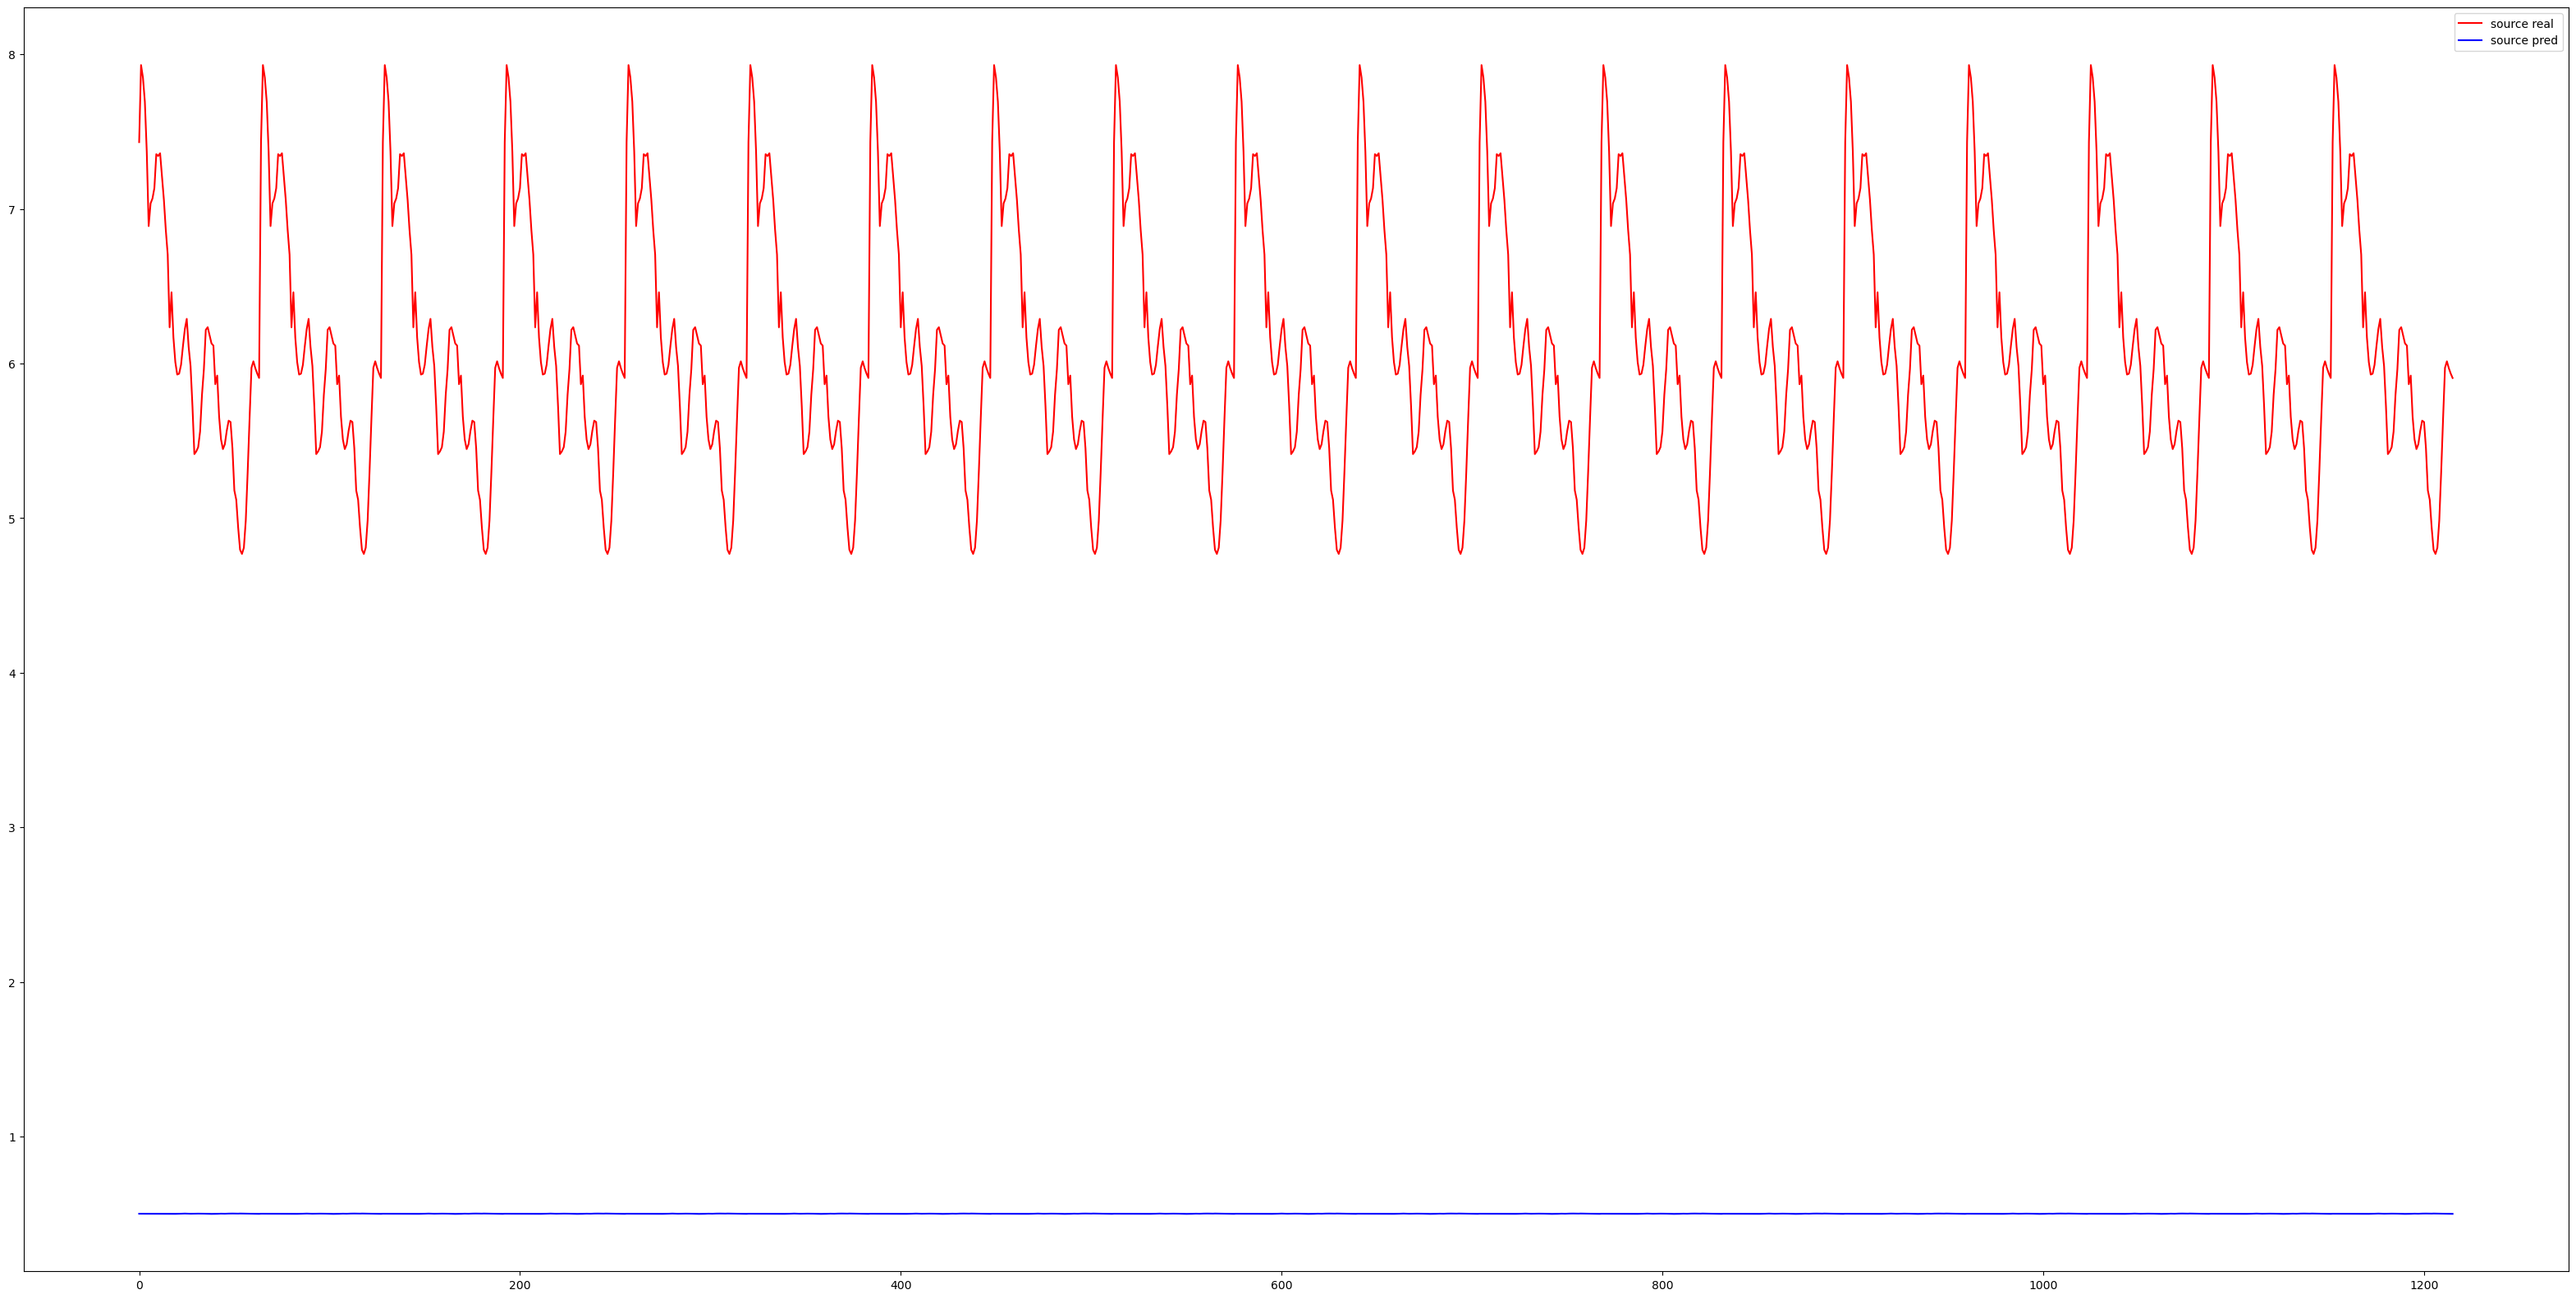

In [ ]:
plt.figure(figsize=(40,20))
plt.plot(s_real, color='red', label='source real')
plt.plot(s_pred, color='blue', label='source pred')
plt.legend()
plt.show()

### Domain Embedding Space 시각화

In [ ]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
source_tsne = DataLoader(nelec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

target_tsne = DataLoader(elec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

source_tsne2 = next(iter(source_tsne))
target_tsne2 = next(iter(target_tsne))

source_x_TNSE = source_tsne2[0].to(device)
source_y_TNSE = source_tsne2[1].to(device)

target_x_TNSE = target_tsne2[0].to(device)
target_y_TNSE = target_tsne2[1].to(device)

# 학습된 모델의 LSTM 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
source_vector = model.lstm(source_x_TNSE)
target_vector = model.lstm(target_x_TNSE)

In [ ]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([source_vector.cpu().detach().numpy(), target_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

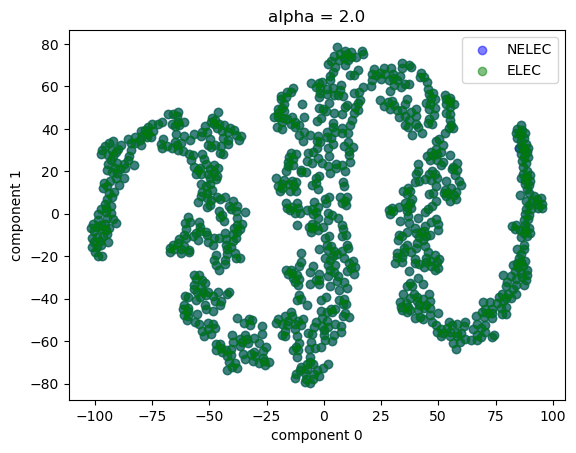

In [ ]:
tsne_df_0 = tsne_df.loc[:1000]
tsne_df_1 = tsne_df.loc[1000:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='blue', label='NELEC', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='green', label='ELEC', alpha=0.5)

plt.title('alpha = '+ str(alpha))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()